In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
train = pd.read_pickle("./data/train_RFE.pkl")
test = pd.read_pickle("./data/test_RFE.pkl")


train_DL = pd.read_pickle("./data/train_DL_RFE.pkl")
test_DL = pd.read_pickle("./data/test_DL_RFE.pkl")
val_DL = pd.read_pickle("./data/validate_DL_RFE.pkl")

In [3]:
def load_data(train, test):
    train_X = np.array(train.loc[:,~train.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    train_Y = np.array(train.pIC50)
    test_X = np.array(test.loc[:,~test.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    test_Y = np.array(test.pIC50)

    return train_X, train_Y, test_X, test_Y

def load_data_DL(train_DL, test_DL, val_DL):
    train_X = np.array(train_DL.loc[:,~train_DL.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    train_Y = np.array(train_DL.pIC50)
    test_X = np.array(test_DL.loc[:,~test_DL.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    test_Y = np.array(test_DL.pIC50)
    val_X = np.array(val_DL.loc[:,~val_DL.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    val_Y = np.array(val_DL.pIC50)

    return train_X, train_Y, test_X, test_Y, val_X, val_Y

def root_mean_squared_error(test_y, pred_y):
    return np.sqrt(mean_squared_error(test_y, pred_y))

def evaluate(train_Y, pred_Y_train, test_Y, pred_Y_test):
    print("Train Root Mean Squared Error:", root_mean_squared_error(train_Y, pred_Y_train))
    print("Train Mean Absolute Error:", mean_absolute_error(train_Y, pred_Y_train))
    print("Train R2:", r2_score(train_Y, pred_Y_train))
    print('\n')
    print("Test Root Mean Squared Error:", mean_squared_error(test_Y, pred_Y_test))
    print("Test Mean Absolute Error:", mean_absolute_error(test_Y, pred_Y_test))
    print("Test R2:", r2_score(test_Y, pred_Y_test))
    print('\n')

def visualizeTrainTest(train_Y, pred_Y_train, test_Y, pred_Y_test):
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(10)

    pred_pairs_train = {key: value for key, value in zip(train_Y, pred_Y_train)}
    # pred_pairs_train = dict(sorted(pred_pairs_train.items()))
    pred_pairs_test = {key: value for key, value in zip(test_Y, pred_Y_test)}
    # pred_pairs_test = dict(sorted(pred_pairs_test.items()))


    axs[0].set_title("Train predictions")
    axs[0].plot(pred_pairs_train.values(), 'o', color="red", label='true data', marker=".", markersize=5)
    axs[0].plot(pred_pairs_train.keys(), color="darkblue", label='predictions')
    axs[0].set_xlabel("Molecules")
    axs[0].set_ylabel("pIC50")
    axs[0].legend()
    axs[0].grid()

    axs[1].set_title("Test predictions")
    axs[1].plot(pred_pairs_test.values(), 'o', color="red", label='true data', marker=".", markersize=5)
    axs[1].plot(pred_pairs_test.keys(), color="darkblue", label='predictions')
    axs[1].set_xlabel("Molecules")
    axs[1].set_ylabel("pIC50")
    axs[1].legend()
    axs[1].grid()

    fig.tight_layout()
    plt.show()

### CNN

In [28]:
train_X, train_Y, test_X, test_Y = load_data(train_DL, test_DL)

train_X = train_X.reshape((train_X.shape[0], 8, 4))
test_X = test_X.reshape((test_X.shape[0], 8, 4))

train_X.shape, test_X.shape

((335, 8, 4), (72, 8, 4))

In [44]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense

X_train = (train_X.astype('float32'))
X_test = test_X.astype('float32')

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')



model_CNN = Sequential()
model_CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model_CNN.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model_CNN.add(Flatten())
model_CNN.add(Dense(128))
model_CNN.add(Dense(32))
model_CNN.add(Dense(1))

model_CNN.compile(loss='mae',
                  optimizer='adam',
                  metrics=['mae'],)


# The following script shows the model_CNN summary:

print(model_CNN.summary())

x_train shape: (335, 8, 4)
335 train samples
72 test samples
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 6, 2, 64)          640       
                                                                 
 conv2d_28 (Conv2D)          (None, 5, 1, 128)         32896     
                                                                 
 flatten_12 (Flatten)        (None, 640)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               82048     
                                                                 
 dense_33 (Dense)            (None, 32)                4128      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                          

In [45]:
X_train = X_train.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2], 1)
X_test = X_test.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2], 1)

from sklearn.model_selection import  KFold
avg_train_loss = []
avg_val_loss = []


N_EPOCHS = 500

for n_epoch in range(N_EPOCHS):
    print('\nEPOCH ', n_epoch+1, '-----------------------------------------------------------------------')
    folds = list(KFold(n_splits=3, shuffle=True, random_state=0).split(train_X, train_Y))
    train_loss = []; train_acc = []
    val_loss = []; val_acc = []

    for j, (train_idx, val_idx) in enumerate(folds):
        print('\nEpoch ', n_epoch, 'Fold ',j)
        X_train_cv = train_X[train_idx]
        y_train_cv = train_Y[train_idx]
        X_valid_cv = train_X[val_idx]
        y_valid_cv = train_Y[val_idx]

        model_CNN.fit(X_train_cv, y_train_cv, batch_size=64, epochs=1, validation_data=(X_valid_cv, y_valid_cv))
        train_loss.append(model_CNN.history.history['loss'])
        val_loss.append(model_CNN.history.history['val_loss'])
    
    avg_train_loss.append(np.average(train_loss))
    avg_val_loss.append(np.average(val_loss))
    print(f'Epoch {n_epoch} - val_loss: {avg_val_loss[-1]}\n')

# history = model_CNN.fit(X_train, train_Y, batch_size = 64, epochs = 50)


EPOCH  1 -----------------------------------------------------------------------

Epoch  0 Fold  0
4/4 [==============================] - 1s 41ms/step - loss: 0.3054 - mae: 0.3054 - val_loss: 0.1697 - val_mae: 0.1697

Epoch  0 Fold  1
4/4 [==============================] - 0s 19ms/step - loss: 0.2063 - mae: 0.2063 - val_loss: 0.2311 - val_mae: 0.2311

Epoch  0 Fold  2
4/4 [==============================] - 0s 19ms/step - loss: 0.1905 - mae: 0.1905 - val_loss: 0.1702 - val_mae: 0.1702
Epoch 0 - val_loss: 0.19031196335951486


EPOCH  2 -----------------------------------------------------------------------

Epoch  1 Fold  0
4/4 [==============================] - 0s 19ms/step - loss: 0.1630 - mae: 0.1630 - val_loss: 0.1802 - val_mae: 0.1802

Epoch  1 Fold  1
4/4 [==============================] - 0s 20ms/step - loss: 0.1659 - mae: 0.1659 - val_loss: 0.1273 - val_mae: 0.1273

Epoch  1 Fold  2
4/4 [==============================] - 0s 19ms/step - loss: 0.1493 - mae: 0.1493 - val_loss: 0.16

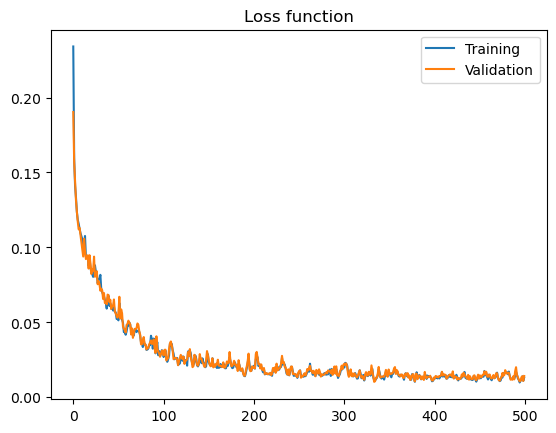

In [46]:
plt.plot(avg_train_loss, label='Training')
plt.plot(avg_val_loss, label='Validation')
plt.title('Loss function')
plt.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step
Train Root Mean Squared Error: 0.017466256268222645
Train Mean Absolute Error: 0.01416113376210821
Train R2: 0.9931398156614556


Test Root Mean Squared Error: 0.04023951042341996
Test Mean Absolute Error: 0.16286850525884167
Test R2: 0.20035400179290175




C:\Users\afs\AppData\Local\Temp\ipykernel_764\3402225866.py:44: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].plot(pred_pairs_train.values(), 'o', color="red", label='true data', marker=".", markersize=5)
C:\Users\afs\AppData\Local\Temp\ipykernel_764\3402225866.py:52: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[1].plot(pred_pairs_test.values(), 'o', color="red", label='true data', marker=".", markersize=5)


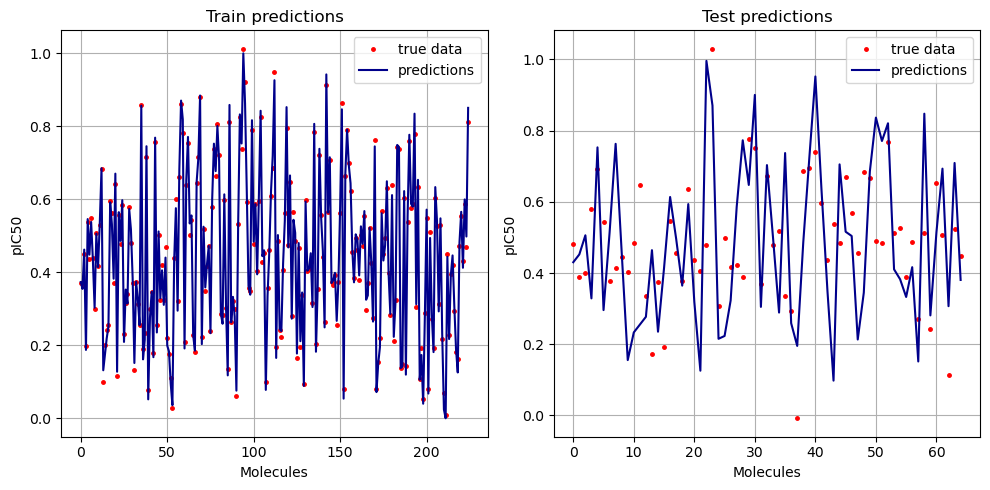

In [47]:
pred_Y_train_dnn = model_CNN.predict(train_X)
pred_Y_test_dnn = model_CNN.predict(test_X)
evaluate(train_Y, pred_Y_train_dnn, test_Y, pred_Y_test_dnn)
visualizeTrainTest(train_Y, pred_Y_train_dnn, test_Y, pred_Y_test_dnn)

In [48]:
for i in range(len(pred_Y_test_dnn)):
    print(pred_Y_test_dnn[i], test_Y[i])

[0.481541] 0.43027888446215157
[0.3889731] 0.4521912350597611
[0.39865375] 0.50597609561753
[0.579819] 0.32868525896414347
[0.66867185] 0.7529880478087653
[0.54262334] 0.29581673306772915
[0.37853706] 0.5132802124840637
[0.41461593] 0.7629482071713148
[0.44387078] 0.458167330677291
[0.40398133] 0.15537848605577687
[0.48505875] 0.23306772908366546
[0.6465171] 0.254980079681275
[0.692742] 0.7529880478087653
[0.3358196] 0.27689243027888455
[0.17142388] 0.46414342629482086
[0.35966498] 0.23505976095617542
[0.54217964] 0.4143426294820717
[0.5458358] 0.6135458167330677
[0.45572203] 0.4960159362549802
[0.5156237] 0.3645418326693227
[0.6360167] 0.5936254980079684
[0.61830467] 0.3187250996015937
[0.4058836] 0.1254980079681277
[0.47973472] 0.9960159362549802
[1.0299245] 0.8705179282868528
[0.35309142] 0.21513944223107584
[0.4970516] 0.22310756972111567
[0.41580468] 0.3227091633466136
[0.42341685] 0.5856573705179283
[0.3896919] 0.7729083665338649
[0.7775982] 0.647410358565737
[0.7517998] 0.900398